In [ ]:
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def dry_solution(IC, t1, t2, dt=0.1, prc=np.float16):
    """ IC = (w0, bu0, bs0) tuple
        we don't need dt, because t1 and t2 would be index instead of the actual time"""
    nt_func = t2-t1
    t = np.arange(nt_func)*dt
    
    w = np.zeros(nt_func,dtype=prc)
    bu = np.zeros(nt_func,dtype=prc)
    bs = np.zeros(nt_func,dtype=prc)
    
    w[0], bu[0], bs[0] = IC
    
    bu = bu[0]*np.cos(Nu*t) - Nu*w[0]*np.sin(Nu*t)
    w = w[0]*np.cos(Nu*t) + 1/Nu * bu[0]*np.sin(Nu*t)
    bs = (bs[0] - (Ns**2/Nu**2)*bu[0]) + (Ns**2/Nu**2)*bu[0]*np.cos(Nu*t) - (Ns**2/Nu)*w[0]*np.sin(Nu*t)
    
    M =  (1/Nu**2 * bu - 1/Ns**2 * bs).astype(np.float16)
    
    return w, bu, bs, M

def moist_solution(IC, t1, t2, prc=np.float16, dt=0.1):
    """ IC = (w0, bu0, bs0) tuple"""
    nt_func = t2-t1
    t = np.arange(nt_func)*dt
    
    w = np.zeros(nt_func,dtype=prc)
    bu = np.zeros(nt_func,dtype=prc)
    bs = np.zeros(nt_func,dtype=prc)
    
    w[0], bu[0], bs[0] = IC
    
    bs = bs[0]*np.cos(Ns*t) - Ns*w[0]*np.sin(Ns*t)
    w = w[0]*np.cos(Ns*t) + 1/Ns * bs[0]*np.sin(Ns*t)
    bu = (bu[0] - (Nu**2/Ns**2)*bs[0]) + (Nu**2/Ns**2)*bs[0]*np.cos(Ns*t) - (Nu**2/Ns)*w[0]*np.sin(Ns*t)
    
    M =  (1/Nu**2 * bu - 1/Ns**2 * bs).astype(np.float16)
    
    return w, bu, bs, M

def nlm_lf(w0, bu0, bs0, nt=50000):
    w = np.zeros(nt)
    bu = np.zeros(nt)
    bs = np.zeros(nt)
    
    w[0] = w0
    bs[0] = bs0
    bu[0] = bu0
    
    dt = 0.1
    
    # leap frog
    for t in range(1):
        if bs[t] > bu[t]:
            w[t+1] = w[t] + bs[t]*dt
        else:
            w[t+1] = w[t] + bu[t]*dt

        bu[t+1] = bu[t] - (Nu**2)*w[t]*dt
        bs[t+1] = bs[t] - (Ns**2)*w[t]*dt



    for t in range(1,nt-1):
        if bs[t] > bu[t]:
            w[t+1] = w[t-1] + bs[t]*2.*dt
        else:
            w[t+1] = w[t-1] + bu[t]*2.*dt

        bu[t+1] = bu[t-1] - (Nu**2)*w[t]*2.*dt
        bs[t+1] = bs[t-1] - (Ns**2)*w[t]*2.*dt
   
    return w, bu, bs

In [ ]:
Nu = 0.12   
Ns = 0.012

nt_global = 50000

w0 = 0.1
bu0 = 0.5
bs0 = 0.1

w_num, bu_num, bs_num = nlm_lf(w0, bu0, bs0, nt=nt_global)

In [ ]:
plt.plot(bu_num, label='bu')
plt.plot(bs_num, label='bs')
plt.legend()
plt.title("numerical solution")

NameError: name 'bu' is not defined

In [5]:
a = np.where(bu_num>bs_num)[0]
b = np.where((a[1:]- a[:-1])>1)[0] #counting the ones on the right 1st, 3rd, 5th, .. intersection
idx_its = sorted([0] + a[b].tolist() + a[b+1].tolist())
print(idx_its)

[0, 112, 4561, 4790, 9239, 9467, 13916, 14145, 18594, 18822, 23271, 23500, 27949, 28178, 32627, 32855, 37304, 37533, 41982, 42210, 46659]


In [10]:
np.array(idx_its[1:])-np.array(idx_its[:-1])

array([ 112, 4449,  229, 4449,  228, 4449,  229, 4449,  228, 4449,  229,
       4449,  229, 4449,  228, 4449,  229, 4449,  228, 4449])

Text(0.5, 1.0, 'numerical solution')

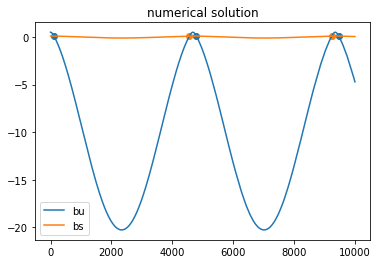

In [8]:
plt.plot(bu_num[:10000], label='bu')
plt.plot(bs_num[:10000], label='bs')
plt.scatter(a[b][:3],bu_num[a[b][:3]])
plt.scatter(a[b[:2]+1],bu_num[a[b[:2]+1]])
plt.legend()
plt.title("numerical solution")

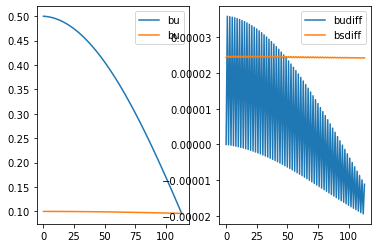

In [86]:
# start with dry phase
w_dry, bu_dry, bs_dry, M = dry_solution(IC=(w0, bu0, bs0), t1=idx_its[0], t2=idx_its[1]+2)

fig,ax = plt.subplots(ncols=2)
ax[0].plot(bu_dry, label='bu')
ax[0].plot(bs_dry, label='bu')
ax[0].legend()

ax[1].plot(bu_num[idx_its[0]:idx_its[1]+2]-bu_dry, label='budiff')
ax[1].plot(bs_num[idx_its[0]:idx_its[1]+2]-bs_dry, label='bsdiff')
ax[1].legend()

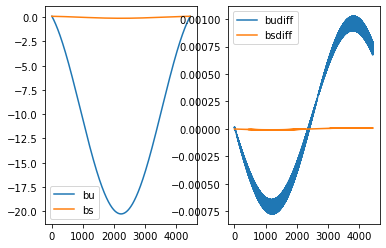

In [87]:
# start with dry phase
w_sat, bu_sat, bs_sat, M = moist_solution(IC=(w_num[idx_its[1]], bu_num[idx_its[1]], bs_num[idx_its[1]]),
                                        t1=idx_its[1], t2=idx_its[2]+1)
fig,ax = plt.subplots(ncols=2)
ax[0].plot(bu_sat, label='bu')
ax[0].plot(bs_sat, label='bs')
ax[0].legend()

ax[1].plot(bu_num[idx_its[1]:idx_its[2]+1]-bu_sat, label='budiff')
ax[1].plot(bs_num[idx_its[1]:idx_its[2]+1]-bs_sat, label='bsdiff')
ax[1].legend()

In [37]:
nt_dry = 250
nt_sat = 4500
nt_ana = 0
flag = 0 # 0 for dry, 1 for moist
t_st = 0
t_ed = 130

w_d, bu_d, bs_d, M = moist_solution((4.08733573966386, 0.09779576146701408, 0.09595354355217015), 113, 4613)
rcd_idx = 5+np.where(bs_d[5:]<=bu_d[5:])[0][0]

print(rcd_idx)
bu0 =(bu_d[rcd_idx-1]+bu_d[rcd_idx])/2
bs0 =(bs_d[rcd_idx-1]+bs_d[rcd_idx])/2
w0 =(w_d[rcd_idx-1]+w_d[rcd_idx])/2

print(bu_d[rcd_idx-1], bs_d[rcd_idx-1])
print(bu_d[rcd_idx], bs_d[rcd_idx])
print(bu_d[rcd_idx+1], bs_d[rcd_idx+1])

4449
0.09418999896146518 0.09591138241148965
0.10007526053893168 0.09597023502726432
0.10594670240420445 0.09602894944591706


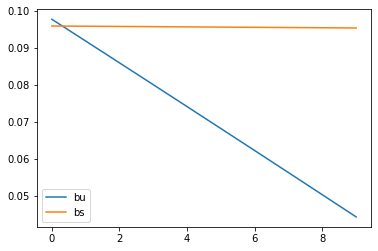

In [34]:
plt.plot(bu_d[:10], label='bu')
plt.plot(bs_d[:10], label='bs')
plt.legend()

In [49]:
nt_dry = 250
nt_sat = 4500
nt_ana = 0
flag = 0 # 0 for dry, 1 for moist
t_st = 0
t_ed = 130

w0 = 0.1
bu0 = 0.5
bs0 = 0.1
#nt_global = 200

bu_ana = []
bs_ana = []
w_ana = []

# [t0,t1), [t1,t2) 
while nt_ana <= nt_global:
    print(t_st, t_ed, t_ed-t_st)
    if flag == 0:
        if t_st == 0:
            w_d, bu_d, bs_d, M = dry_solution((w0, bu0, bs0), t_st, t_ed)

        else:
            w_d, bu_d, bs_d, M = dry_solution((w0, bu0, bs0), t_st, t_ed, )
        rcd_idx = 5+np.where(bu_d[5:]<=bs_d[5:])[0][0]
        nt_ana += rcd_idx-1
        t_st = nt_ana+1
        t_ed = t_st + nt_sat

        bu0 =(bu_d[rcd_idx-1]+bu_d[rcd_idx])/2
        bs0 =(bs_d[rcd_idx-1]+bs_d[rcd_idx])/2
        w0 =(w_d[rcd_idx-1]+w_d[rcd_idx])/2
        
        bu_ana += bu_d[:rcd_idx].tolist()
        bs_ana += bs_d[:rcd_idx].tolist()
        w_ana += w_d[:rcd_idx].tolist()
        
        flag = 1
        
    else:
        w_s, bu_s, bs_s, M = moist_solution((w0, bu0, bs0), t_st, t_ed)
        rcd_idx = 5+np.where(bs_s[5:]<=bu_s[5:])[0][0]
        nt_ana += rcd_idx-1
        t_st = nt_ana+1
        t_ed = t_st + nt_dry
        
        bu0 =(bu_s[rcd_idx-1]+bu_s[rcd_idx])/2
        bs0 =(bs_s[rcd_idx-1]+bs_s[rcd_idx])/2
        w0 =(w_s[rcd_idx-1]+w_s[rcd_idx])/2
        
        bu_ana += bu_s[:rcd_idx].tolist()
        bs_ana += bs_s[:rcd_idx].tolist()
        w_ana += w_s[:rcd_idx].tolist()

        flag = 0

0 130 130
113 4613 4500
4561 4811 250
4790 9290 4500
9238 9488 250
9467 13967 4500
13914 14164 250
14143 18643 4500
18590 18840 250
18819 23319 4500
23266 23516 250
23495 27995 4500
27942 28192 250
28171 32671 4500
32618 32868 250
32847 37347 4500
37294 37544 250
37523 42023 4500
41970 42220 250
42199 46699 4500
46646 46896 250
46875 51375 4500


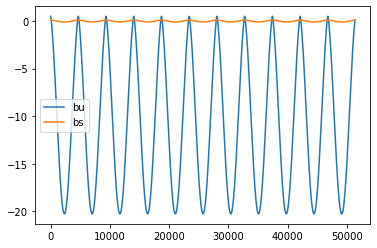

In [50]:
fig = plt.figure()
plt.plot(bu_ana, label='bu')
plt.plot(bs_ana, label='bs')
plt.legend()

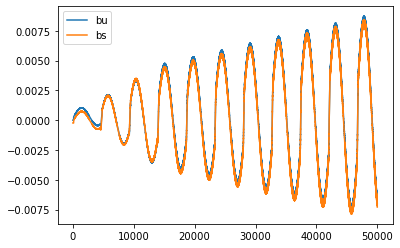

In [56]:
fig = plt.figure()
plt.plot((bu_ana[:50000]-bu_num)/10.38, label='bu')
plt.plot((bs_ana[:50000]-bs_num)/0.1038, label='bs')
plt.legend()

In [55]:
(bu_num.max() - bu_num.min())/2, (bs_num.max() - bs_num.min())/2

(10.389402960954563, 0.1038940296095456)